In [1]:
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set(**{
      "xlim": lims,
      "ylim": lims,
      "aspect": "equal"
  })
  return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
mtx = mmread("tags_out/counts_filtered/cells_x_features.mtx").tocsr().astype(int)
genes = pd.read_csv("tags_out/counts_filtered/cells_x_features.genes.txt", header=None, names=["genes"])
barcodes = pd.read_csv("tags_out/counts_filtered/cells_x_features.barcodes.txt", header=None, names=["barcodes"])

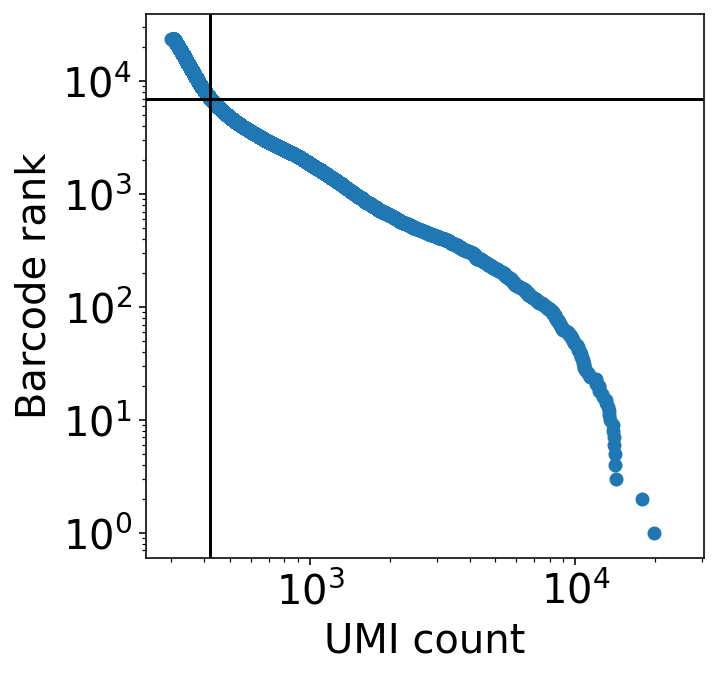

In [13]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.sort(nd(mtx.sum(1)))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x,y)
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMI count",
    "ylabel": "Barcode rank"
})

lim = 420
ind = np.where(x > lim)[0][-1]
cutoff = x[ind]
ax.axvline(x=cutoff, color="k")
ax.axhline(y=ind, color="k")

fig.show()

In [14]:
print(f"{ind:,.0f} cells have more than {lim} UMI counts")

7,034 cells have more than 420 UMI counts


In [15]:
mask = nd(mtx.sum(1) > lim)

# Save filtered matrix, barcodes, genes, and dbco counts as cell metadata

In [40]:
!mkdir -p out
!cp tags_out/*.json out/

# masked barcodes
barcodes[mask].to_csv("out/barcodes.txt.gz", header=False, index=False, compression="gzip")

# genes without dbco
genes.query("genes != 'dbco'").to_csv("out/genes.txt.gz", header=False, index=False, compression="gzip")

# masked matrix (without barcodes or dbco)
mmwrite("out/matrix.mtx", mtx[mask][:,genes.genes.values!="dbco"])

# dbco vector
dbco = mtx[:,genes.genes.values=="dbco"].toarray().flatten()[mask]
pd.Series(dbco).to_csv("out/dbco.txt.gz", header=False, sep="\t", index=False, compression="gzip")

!gzip "out/matrix.mtx"